In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
)
import warnings

warnings.filterwarnings("ignore")

# Import classifiers
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import json
from datetime import datetime

In [18]:
def load_and_prepare_data(filepath):
    """Load feature-engineered dataset and prepare for training"""
    print("=" * 70)
    print("LOADING DATA")
    print("=" * 70)

    df = pd.read_csv(filepath)
    print(f"Dataset shape: {df.shape}")

    # Separate features and target
    X = df.drop(["url", "result"], axis=1)
    y = df["result"]
    urls = df["url"]  # Keep URLs for reference

    print(f"\nFeatures shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"\nClass distribution:")
    print(f"  Legitimate (0): {(y==0).sum()} ({(y==0).sum()/len(y)*100:.2f}%)")
    print(f"  Phishing (1): {(y==1).sum()} ({(y==1).sum()/len(y)*100:.2f}%)")

    # Check for any missing values
    missing = X.isnull().sum().sum()
    if missing > 0:
        print(f"\n⚠️ WARNING: Found {missing} missing values. Filling with 0...")
        X = X.fillna(0)

    # Check for infinite values
    inf_count = np.isinf(X).sum().sum()
    if inf_count > 0:
        print(f"\n⚠️ WARNING: Found {inf_count} infinite values. Replacing with 0...")
        X = X.replace([np.inf, -np.inf], 0)

    return X, y, urls, X.columns.tolist()

In [19]:
def create_pipelines():
    """Create sklearn pipelines for all models"""
    print("\n" + "=" * 70)
    print("CREATING MODEL PIPELINES")
    print("=" * 70)

    pipelines = {
        "Logistic Regression": Pipeline(
            [
                ("scaler", StandardScaler()),
                ("classifier", LogisticRegression(random_state=42, max_iter=1000)),
            ]
        ),
        "Decision Tree": Pipeline(
            [
                ("scaler", StandardScaler()),
                ("classifier", DecisionTreeClassifier(random_state=42)),
            ]
        ),
        "Random Forest": Pipeline(
            [
                ("scaler", StandardScaler()),
                (
                    "classifier",
                    RandomForestClassifier(
                        n_estimators=100, random_state=42, n_jobs=-1
                    ),
                ),
            ]
        ),
        "Gradient Boosting": Pipeline(
            [
                ("scaler", StandardScaler()),
                (
                    "classifier",
                    GradientBoostingClassifier(n_estimators=100, random_state=42),
                ),
            ]
        ),
        "XGBoost": Pipeline(
            [
                ("scaler", StandardScaler()),
                (
                    "classifier",
                    XGBClassifier(
                        n_estimators=100,
                        random_state=42,
                        eval_metric="logloss",
                        n_jobs=-1,
                    ),
                ),
            ]
        ),
        "LightGBM": Pipeline(
            [
                ("scaler", StandardScaler()),
                (
                    "classifier",
                    LGBMClassifier(
                        n_estimators=100, random_state=42, n_jobs=-1, verbose=-1
                    ),
                ),
            ]
        ),
        # "SVM": Pipeline(
        #     [
        #         ("scaler", StandardScaler()),
        #         ("classifier", SVC(kernel="rbf", probability=True, random_state=42)),
        #     ]
        # ),
        "CatBoost": CatBoostClassifier(
            iterations=200,
            depth=10,
            learning_rate=0.1,
            random_state=42,
            verbose=False,
        ),
        "Naive Bayes": Pipeline(
            [("scaler", StandardScaler()), ("classifier", GaussianNB())]
        ),
        "KNN": Pipeline(
            [
                ("scaler", StandardScaler()),
                ("classifier", KNeighborsClassifier(n_neighbors=5, n_jobs=-1)),
            ]
        ),
        "AdaBoost": Pipeline(
            [
                ("scaler", StandardScaler()),
                ("classifier", AdaBoostClassifier(n_estimators=100, random_state=42)),
            ]
        ),
    }

    print(f"✅ Created {len(pipelines)} model pipelines")
    return pipelines

In [20]:
def train_baseline_models(pipelines, X_train, X_test, y_train, y_test):
    """Train multiple baseline models using pipelines and compare performance"""
    print("\n" + "=" * 70)
    print("TRAINING BASELINE MODELS")
    print("=" * 70)

    results = []
    trained_pipelines = {}

    for name, pipeline in pipelines.items():
        print(f"\nTraining {name}...")

        # Train pipeline (scaling + model)
        pipeline.fit(X_train, y_train)

        # Predictions
        y_pred = pipeline.predict(X_test)
        y_pred_proba = (
            pipeline.predict_proba(X_test)[:, 1]
            if hasattr(pipeline, "predict_proba")
            else None
        )

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        if y_pred_proba is not None:
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        else:
            roc_auc = None

        # Store results
        results.append(
            {
                "Model": name,
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1-Score": f1,
                "ROC-AUC": roc_auc,
            }
        )

        trained_pipelines[name] = pipeline

        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        if roc_auc:
            print(f"  ROC-AUC: {roc_auc:.4f}")

    # Create results DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values("F1-Score", ascending=False).reset_index(
        drop=True
    )

    print("\n" + "=" * 70)
    print("MODEL COMPARISON (sorted by F1-Score)")
    print("=" * 70)
    print(results_df.to_string(index=False))

    return results_df, trained_pipelines

In [21]:
def evaluate_final_model(
    pipeline, X_train, X_test, y_train, y_test, model_name, feature_names
):
    """Comprehensive evaluation of the final model pipeline"""
    print("\n" + "=" * 70)
    print(f"FINAL MODEL EVALUATION: {model_name}")
    print("=" * 70)

    # Predictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Prediction probabilities
    if hasattr(pipeline, "predict_proba"):
        y_test_proba = pipeline.predict_proba(X_test)[:, 1]
    else:
        y_test_proba = None

    # Training metrics
    print("\n📊 TRAINING SET PERFORMANCE:")
    print(f"  Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"  Precision: {precision_score(y_train, y_train_pred):.4f}")
    print(f"  Recall: {recall_score(y_train, y_train_pred):.4f}")
    print(f"  F1-Score: {f1_score(y_train, y_train_pred):.4f}")

    # Test metrics
    print("\n📊 TEST SET PERFORMANCE:")
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

    if y_test_proba is not None:
        roc_auc = roc_auc_score(y_test, y_test_proba)
        print(f"  ROC-AUC: {roc_auc:.4f}")
    else:
        roc_auc = None

    # Confusion Matrix
    print("\n📊 CONFUSION MATRIX:")
    cm = confusion_matrix(y_test, y_test_pred)
    print(cm)
    print(f"\n  True Negatives (Legitimate correctly identified): {cm[0,0]}")
    print(f"  False Positives (Legitimate incorrectly flagged): {cm[0,1]}")
    print(f"  False Negatives (Phishing missed): {cm[1,0]}")
    print(f"  True Positives (Phishing correctly identified): {cm[1,1]}")

    # Classification Report
    print("\n📊 CLASSIFICATION REPORT:")
    print(
        classification_report(
            y_test, y_test_pred, target_names=["Legitimate", "Phishing"]
        )
    )

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc,
        "confusion_matrix": cm,
        "classification_report": classification_report(
            y_test,
            y_test_pred,
            target_names=["Legitimate", "Phishing"],
            output_dict=True,
        ),
    }

In [22]:
def save_model_artifacts(pipeline, metrics, best_model_name, feature_names):
    """Save only the best model and scaler from the pipeline, plus feature names and metadata"""
    print("\n" + "=" * 70)
    print("SAVING BEST MODEL ARTIFACTS")
    print("=" * 70)

    # Save only the best model (estimator) and scaler separately
    model_filename = f"/home/maliha/Programming/dm/Phishing-Website-Classifier/training/utilities/url/best_model.joblib"
    scaler_filename = f"/home/maliha/Programming/dm/Phishing-Website-Classifier/training/utilities/url/best_scaler   .joblib"

    # Extract model and scaler from pipeline
    best_model = pipeline[best_model_name]
    if hasattr(pipeline, "named_steps"):
        scaler = pipeline.named_steps["scaler"]
    elif hasattr(pipeline[best_model_name], "scaler"):
        scaler = pipeline[best_model_name].scaler
    else:
        scaler = None  # CatBoost or other non-pipeline models

    joblib.dump(best_model, model_filename)
    print(f"✅ Best model saved to: {model_filename}")
    if scaler == None:
        print("⚠️ WARNING: No scaler found to save.")
    else:
        joblib.dump(scaler, scaler_filename)
        print(f"✅ Scaler saved to: {scaler_filename}")

    return model_filename, scaler_filename

In [23]:
def plot_results(results_df, final_metrics, model_name):
    """Create comprehensive visualization plots"""
    print("\n" + "=" * 70)
    print("GENERATING VISUALIZATIONS")
    print("=" * 70)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Model Comparison (F1-Scores)
    ax1 = axes[0, 0]
    results_plot = results_df.sort_values("F1-Score", ascending=True)
    bars = ax1.barh(results_plot["Model"], results_plot["F1-Score"], color="skyblue")
    ax1.set_xlabel("F1-Score", fontsize=12)
    ax1.set_title("Model Comparison - F1 Scores", fontsize=14, fontweight="bold")
    ax1.grid(axis="x", alpha=0.3)

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax1.text(
            width,
            bar.get_y() + bar.get_height() / 2.0,
            f"{width:.4f}",
            ha="left",
            va="center",
            fontsize=9,
        )

    # Plot 2: Metrics Comparison for all models
    ax2 = axes[0, 1]
    metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1-Score"]
    x = np.arange(len(results_df))
    width = 0.2

    colors = ["#ff9999", "#66b3ff", "#99ff99", "#ffcc99"]
    for i, metric in enumerate(metrics_to_plot):
        ax2.bar(x + i * width, results_df[metric], width, label=metric, color=colors[i])

    ax2.set_xlabel("Models", fontsize=12)
    ax2.set_ylabel("Score", fontsize=12)
    ax2.set_title(
        "All Models - Multiple Metrics Comparison", fontsize=14, fontweight="bold"
    )
    ax2.set_xticks(x + width * 1.5)
    ax2.set_xticklabels(results_df["Model"], rotation=45, ha="right")
    ax2.legend()
    ax2.grid(axis="y", alpha=0.3)

    # Plot 3: Confusion Matrix Heatmap
    ax3 = axes[1, 0]
    cm = final_metrics["confusion_matrix"]
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=ax3,
        xticklabels=["Legitimate", "Phishing"],
        yticklabels=["Legitimate", "Phishing"],
        cbar_kws={"label": "Count"},
    )
    ax3.set_title(f"Confusion Matrix - {model_name}", fontsize=14, fontweight="bold")
    ax3.set_ylabel("Actual", fontsize=12)
    ax3.set_xlabel("Predicted", fontsize=12)

    # Plot 4: Final Model Metrics
    ax4 = axes[1, 1]
    final_metrics_values = [
        final_metrics["accuracy"],
        final_metrics["precision"],
        final_metrics["recall"],
        final_metrics["f1_score"],
    ]
    final_metrics_names = ["Accuracy", "Precision", "Recall", "F1-Score"]

    colors = ["#ff9999", "#66b3ff", "#99ff99", "#ffcc99"]
    bars = ax4.bar(
        final_metrics_names,
        final_metrics_values,
        color=colors,
        edgecolor="black",
        linewidth=1.5,
    )
    ax4.set_ylim([0, 1.1])
    ax4.set_title(
        f"Final Model Performance - {model_name}", fontsize=14, fontweight="bold"
    )
    ax4.set_ylabel("Score", fontsize=12)
    ax4.grid(axis="y", alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax4.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.02,
            f"{height:.4f}",
            ha="center",
            va="bottom",
            fontsize=11,
            fontweight="bold",
        )

    plt.tight_layout()

    plt.show()


PHISHING URL DETECTION - MODEL TRAINING WITH PIPELINES

LOADING DATA
Dataset shape: (79847, 50)

Features shape: (79847, 48)
Target shape: (79847,)

Class distribution:
  Legitimate (0): 49853 (62.44%)
  Phishing (1): 29994 (37.56%)

SPLITTING DATA
Training set size: 63877 (80.00%)
Test set size: 15970 (20.00%)

CREATING MODEL PIPELINES
✅ Created 10 model pipelines

TRAINING BASELINE MODELS

Training Logistic Regression...
  Accuracy: 0.8798
  Precision: 0.8602
  Recall: 0.8121
  F1-Score: 0.8355
  ROC-AUC: 0.9496

Training Decision Tree...
  Accuracy: 0.8964
  Precision: 0.8584
  Recall: 0.8673
  F1-Score: 0.8629
  ROC-AUC: 0.8916

Training Random Forest...
  Accuracy: 0.9319
  Precision: 0.9153
  Recall: 0.9022
  F1-Score: 0.9087
  ROC-AUC: 0.9774

Training Gradient Boosting...
  Accuracy: 0.8981
  Precision: 0.8980
  Recall: 0.8221
  F1-Score: 0.8584
  ROC-AUC: 0.9619

Training XGBoost...
  Accuracy: 0.9337
  Precision: 0.9215
  Recall: 0.9002
  F1-Score: 0.9107
  ROC-AUC: 0.9816



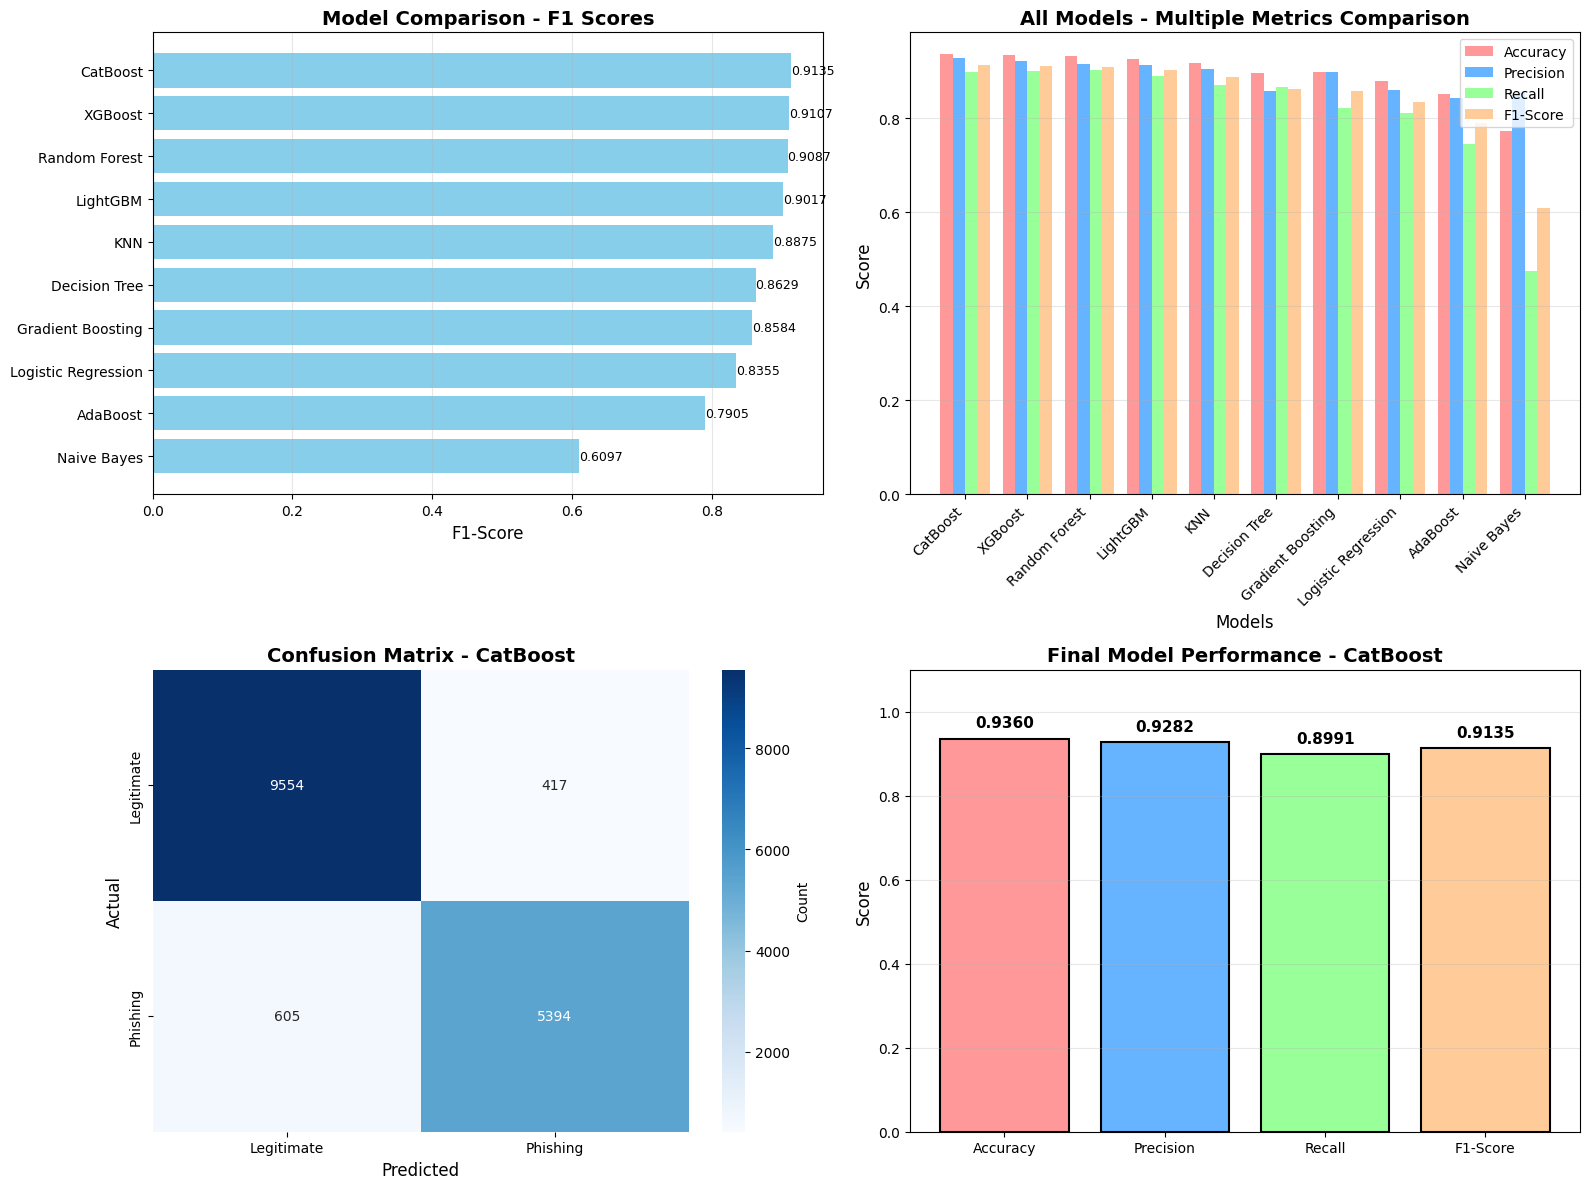


🎉 TRAINING COMPLETE!

📊 FINAL RESULTS:
  Best Model: CatBoost
  Test Accuracy: 0.9360
  Test Precision: 0.9282
  Test Recall: 0.8991
  Test F1-Score: 0.9135
  Test ROC-AUC: 0.9820

💡 TO USE THE MODEL:
  Run: python load_model.py
  Or directly load: joblib.load('('/home/maliha/Programming/dm/Phishing-Website-Classifier/training/utilities/url/best_model.joblib', '/home/maliha/Programming/dm/Phishing-Website-Classifier/training/utilities/url/best_scaler   .joblib')')



In [24]:
print("\n" + "=" * 70)
print("PHISHING URL DETECTION - MODEL TRAINING WITH PIPELINES")
print("=" * 70 + "\n")

# 1. Load and prepare data
X, y, urls, feature_names = load_and_prepare_data(
    "/home/maliha/Programming/dm/Phishing-Website-Classifier/url_features_dataset.csv"
)

# 2. Split data (no need to scale here - pipeline handles it)
print("\n" + "=" * 70)
print("SPLITTING DATA")
print("=" * 70)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.2f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.2f}%)")

# 3. Create pipelines
pipelines = create_pipelines()

# 4. Train baseline models (each pipeline includes scaling)
results_df, trained_pipelines = train_baseline_models(
    pipelines, X_train, X_test, y_train, y_test
)

# 5. Select best model
best_model_name = results_df.iloc[0]["Model"]

print(f"\n{'='*70}")
print(f"🏆 BEST PERFORMING MODEL: {best_model_name}")
print(f"{'='*70}")
print(f"F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")
print(f"Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")
print(f"Precision: {results_df.iloc[0]['Precision']:.4f}")
print(f"Recall: {results_df.iloc[0]['Recall']:.4f}")


# 7. Evaluate final model
final_metrics = evaluate_final_model(
    trained_pipelines[best_model_name],
    X_train,
    X_test,
    y_train,
    y_test,
    best_model_name,
    feature_names,
)

# 8. Save all model artifacts
pipeline_filename = save_model_artifacts(
    trained_pipelines, final_metrics, best_model_name, feature_names
)

# 9. Generate visualizations
plot_results(results_df, final_metrics, best_model_name)

# 10. Final summary
print("\n" + "=" * 70)
print("🎉 TRAINING COMPLETE!")
print("=" * 70)
print(f"\n📊 FINAL RESULTS:")
print(f"  Best Model: {best_model_name}")
print(f"  Test Accuracy: {final_metrics['accuracy']:.4f}")
print(f"  Test Precision: {final_metrics['precision']:.4f}")
print(f"  Test Recall: {final_metrics['recall']:.4f}")
print(f"  Test F1-Score: {final_metrics['f1_score']:.4f}")
if final_metrics["roc_auc"]:
    print(f"  Test ROC-AUC: {final_metrics['roc_auc']:.4f}")


print(f"\n💡 TO USE THE MODEL:")
print(f"  Run: python load_model.py")
print(f"  Or directly load: joblib.load('{pipeline_filename}')")

print("\n" + "=" * 70)